# **Artificial Intelligence - Assignment 3 -  Practical Part**
### Mohammad Reza Nemati - 810100226
---
## **Clustering**
### Overview:
In this project, the primary focus is on clustering a dataset of flower images. The process involves extracting features from the images using the `VGG16` model, a pre-trained convolutional neural network. This model is chosen due to its ability to capture high-level features from images, which are more informative than raw pixel values. The extracted features are then used as input to two different clustering algorithms: `K-means` and `DBSCAN`.

 These algorithms are chosen for their unique strengths: K-means for its efficiency and effectiveness with spherical clusters, and DBSCAN for its ability to discover clusters of arbitrary shape and separate high density clusters from low density noise. The performance of the clustering algorithms are evaluated using two metrics: the Silhouette Score and the Homogeneity Score.


---


In [388]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.neighbors import NearestNeighbors

from skimage import color, exposure


### Preprocess and Feature Extraction

The `include_top=False` argument in the VGG16 model instantiation refers to whether or not the fully-connected layers at the top of the model should be included. When we set `include_top=False`, we're telling Keras to exclude these fully connected layers. This is typically done when we want to use the VGG16 model for feature extraction in a transfer learning scenario.
By excluding the top layers, we can feed custom images into the model.

In [389]:
base_model = VGG16(weights='imagenet', include_top=False)

# model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)
model = Model(inputs=base_model.input, outputs=base_model.output)


#### **Question 1.**

Here's why we choose to extract the features instead of using pixel explcitly:

1. **High-Level Features**: VGG16 can extract high-level features (like edges, textures, shapes) that are more informative than raw pixel values. These features can capture the content of the image better than just the color or intensity of individual pixels.

2. **Dimensionality Reduction**: Images, especially high-resolution ones, can have thousands or even millions of pixels. This high dimensionality can make clustering challenging. VGG16 transforms each image into a fixed-length vector of features, significantly reducing the dimensionality of the data.

3. **Invariance**: The features extracted by VGG16 are invariant to scale, translation, and rotation. This means that even if an image is zoomed in, moved around, or rotated, the features extracted by VGG16 will be similar. This is a desirable property for many tasks, including image clustering.

#### **Question 2.**

Here are three techniques for feature extraction from images:

1. **Convolutional Neural Networks (CNNs)**: CNNs are a class of deep learning models that are especially good at image processing. They can learn to extract complex features from images, using multiple layers of convolutions. Pre-trained CNNs, like VGG16 or ResNet, can be used as feature extractors by taking the output of one of the last layers.

2. **Histogram of Oriented Gradients (HOG)**: This technique involves counting the occurrences of gradient orientation in localized portions of an image. It's often used in object detection tasks, including face and pedestrian detection.

3. **Scale-Invariant Feature Transform (SIFT)**: SIFT detects and describes local features in images. The features are invariant to image scale and rotation, and are shown to provide robust matching across a substantial range of affine distortion, change in 3D viewpoint, addition of noise, and change in illumination.


#### **Question 3.**

Before feeding an image into a model like VGG16, there are several preprocessing steps that are typically performed:

1. **Image Resizing**: VGG16, like many CNNs, expects input images to be a certain size. For VGG16, the expected input size is 224x224 pixels. So, the first step is usually to resize the image to these dimensions.

2. **Color Channel Ordering**: VGG16 was trained on images with the channels ordered as RGB (Red, Green, Blue). So, you need to ensure that your image also uses this channel ordering.

3. **Pixel Scaling**: The pixel values in an image are typically in the range [0, 255]. However, neural networks work best with smaller input values. So, it's common to scale the pixel values to the range [0, 1] or [-1, 1] or to standardize the values (subtract mean and divide by standard deviation).

4. **Batch Dimension**: Keras models expect to be given batches of images. So, even if you're only processing one image, you need to add an extra dimension to the image array to represent the batch dimension.


All of these preprocess are done in the `extract_features` function.

In [390]:
def extract_features(path, model):
    img = image.load_img(path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    return model.predict(img_array)

In [391]:
dir = "./drive/MyDrive/flower_images"
all_images = glob.glob(f"{dir}/*.png")
all_images.sort()
image_features = []
labels = []
for path in all_images:
    image_features.append(extract_features(path, model))
    num = path.split("/")[-1]
    labels.append(num)

1/1 [==============================] - 0s 19ms/step


Now we make the extracted features ready for learning models. Also we read the labels from the files.

In [392]:
image_features = np.array(image_features)
image_features = image_features.reshape(image_features.shape[0], -1)
image_features_pca = PCA(n_components=2).fit_transform(image_features)
flower_data = pd.read_csv(f"{dir}/flower_labels.csv")
flower_data = flower_data.set_index('file').loc[labels]

### Clustring Implementation

#### **Question 4.**



**K-means** is a centroid-based clustering algorithm that partitions the dataset into K distinct, non-overlapping clusters.

##### Pros of K-means
- Simple and easy to implement.
- Efficient in terms of computational cost.
- Works well with spherical clusters and large datasets.

##### Cons of K-means
- Requires the number of clusters (K) to be specified in advance.
- Sensitive to initial centroid placement.
- Struggles with non-spherical and differently sized clusters.

**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm that creates clusters based on the density of data points in a region.

##### Pros of DBSCAN
- Doesn't require the number of clusters to be specified in advance.
- Can discover clusters of arbitrary shape.
- Good at separating high density clusters from low density noise.

##### Cons of DBSCAN
- Sensitive to the choice of density parameters (`eps` and `min_samples`).
- Struggles with clusters of varying density.
- Not as efficient with high-dimensional data.

#### K-Means

#### **Question 5.**

For clustring with K-Means method, we need a `k`. We use **Elbow Plot** to determine best number for the `k`.

**Elbow Plot** is a graphical tool used in determining the optimal number of clusters in a dataset. The plot shows the variance explained as a function of the number of clusters. The "elbow" point, where the rate of decrease sharply shifts, indicates the optimal number of clusters.

In [393]:
def run_elbow_plot(data, k_values):
    inertia = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(12, 7))
    plt.plot(k_values, inertia, marker='o')
    plt.xticks(k_values)
    plt.grid(visible=True)
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

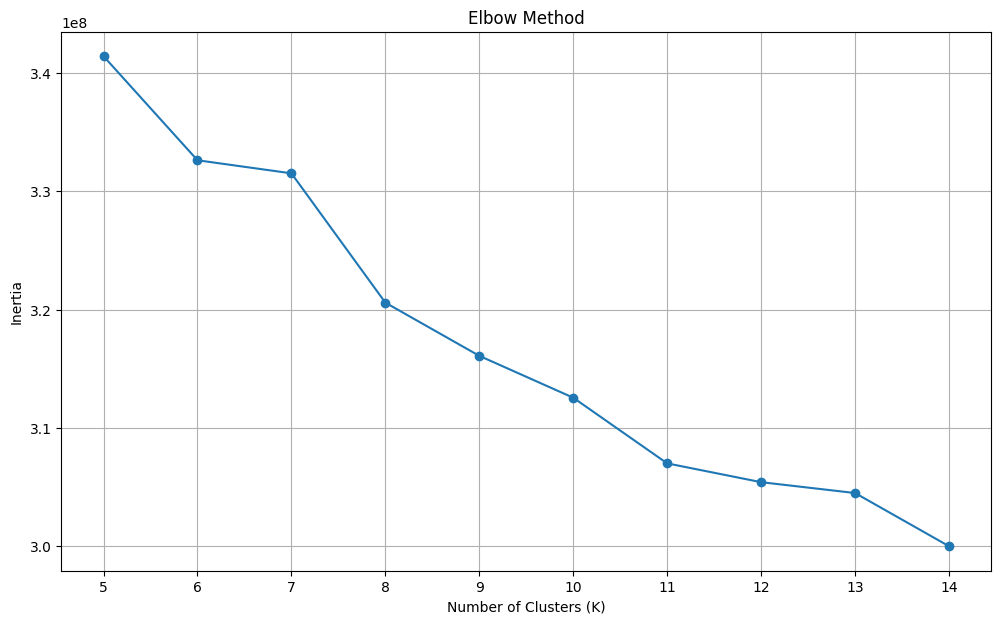

In [394]:
run_elbow_plot(image_features, range(5, 15))

We can see that based on this plot, `k=6` and `k=10` are probably good choices as we also have 10 different types of flowers.

In [395]:
def run_k_means(data, num_clusters, log=False):
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(data)

    s1 = silhouette_score(data, clusters)
    h1 = homogeneity_score(flower_data['label'], clusters)
    if (log):
        print("-----------------------------------------")
        print(f"Results for k = {num_clusters}")
        print("\tSilhouette Score: ", s1)
        print("\tHomogeneity Score: ", h1)
        return
    return (kmeans, clusters)


In [396]:
run_k_means(image_features, num_clusters=6, log=True)
run_k_means(image_features, num_clusters=10, log=True)

-----------------------------------------
Results for k = 6
	Silhouette Score:  0.0115413405
	Homogeneity Score:  0.3874228881263079
-----------------------------------------
Results for k = 10
	Silhouette Score:  0.027451342
	Homogeneity Score:  0.5332674652843431


As we're not getting good results, we use the PCA to reduce the number of dimensions then run the K-Means.

In [397]:
run_k_means(image_features_pca, num_clusters=6, log=True)
run_k_means(image_features_pca, num_clusters=10, log=True)

-----------------------------------------
Results for k = 6
	Silhouette Score:  0.40441364
	Homogeneity Score:  0.3666008004069471
-----------------------------------------
Results for k = 10
	Silhouette Score:  0.39352483
	Homogeneity Score:  0.4635559813225985


The **Silhouette Score** is a measure of how well each data point fits within its assigned cluster and how poorly it fits into other clusters. A higher Silhouette Score indicates that the data points are well-clustered, and the clusters are distinct and well-separated. In this case, the Silhouette Score for `k=6` is 1% better than for `k=10`.

However, the **Homogeneity Score** is a measure of whether each cluster contains only members of a single class. A higher Homogeneity Score indicates that the clusters align well with the pre-existing classes or labels in the data. Here, the Homogeneity Score for `k=10` is about 10 percent higher than for `k=6`, suggesting that the ten-cluster solution aligns better with the existing labels.

This highlights a common challenge in clustering: the number of clusters that optimizes one criterion (like the Silhouette Score) might not optimize another (like the Homogeneity Score). The best choice can depend on the specific goals and context of the analysis. In this case, if the goal is to create well-separated clusters, `k=6` might be the best choice. But if the goal is to align the clusters with existing labels, `k=10` might be more appropriate, despite its lower Silhouette Score.

#### DBSCAN

 A `k-distance graph` can help us determine a good value for `eps` in DBSCAN. In the resulting plot, the `eps` parameter for DBSCAN corresponds to the "elbow" point, i.e., the point of maximum curvature. This is typically where distances start to increase the most when points are sorted by their distance to their kth nearest neighbor.

In [398]:
def run_k_distance_graph(data):
    nn = NearestNeighbors(n_neighbors=2)
    nbrs = nn.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]

    plt.plot(distances)
    plt.ylabel('k-distance')
    plt.xlabel('epsilon')
    plt.grid(True)
    plt.show()

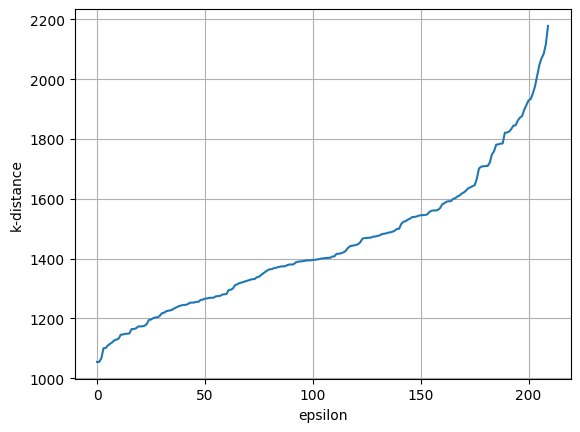

In [399]:
run_k_distance_graph(image_features)

We choose `eps=160` as it seems an elbow point in the plot.

In [400]:
def run_dbscan(data, eps, min_samples, log=False):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data)
    if len(np.unique(clusters)) == 1:
        print("Clustring Failed!")
        return
    s2 = silhouette_score(data, clusters)
    h2 = homogeneity_score(flower_data['label'], clusters)
    if (log):
        print("-----------------------------------------")
        print(f"Results for epsilon = {eps}")
        print("\tSilhouette Score: ", s2)
        print("\tHomogeneity Score: ", h2)
        return
    return clusters

In [401]:
run_dbscan(image_features, eps=160, min_samples=5, log=True)

Clustring Failed!


We can see that the clustring with these parameters have failed and the DBSCAN have clusterd all the data as noise.

One the solutions to this is to reduce the number of dimensions of the data. We will further explain this, but now, for the sake of the results, we use the PCA to reduce the number of dimensions then run the DBSCAN.

In [402]:
run_dbscan(image_features_pca, eps=160, min_samples=5, log=True)

-----------------------------------------
Results for epsilon = 160
	Silhouette Score:  0.51823324
	Homogeneity Score:  0.19033383689175004


#### **Question 6.**


 A higher Silhouette Score indicates that the data points are well-clustered, and the clusters are distinct and well-separated. In our tests, DBSCAN has a higher Silhouette Score (51%) compared to K-means (40%). This suggests that DBSCAN is doing a better job of separating the clusters.

On the other hand, the **Homogeneity Score** indicates that the clusters align well with the pre-existing classes or labels in the data. Here, K-means has a higher Homogeneity Score (46%) compared to DBSCAN (19%), suggesting that K-means is doing a better job of aligning the clusters with the existing labels.

This could be due to the fact that K-means is a centroid-based algorithm that tends to create spherical clusters, which might align better with the labels. DBSCAN, on the other hand, is a density-based algorithm that can create clusters of arbitrary shapes, which might result in better separation between clusters but less alignment with the labels.


### Dimension Reduction

#### **Question 7.**



Given the complexity and high-dimensionality of the data, direct analysis and visualization were challenging.

To address this, Principal Component Analysis (PCA) was used. PCA works by identifying the axes in the feature space along which the data varies the most and then projecting the data onto these axes. The result is a set of new features called principal components, which are uncorrelated and capture the majority of the variance in the data.


We used PCA to reduce the dimensionality of our data down to two dimensions. This choice was motivated by our desire to visualize the data, as two-dimensional plots are easy to create and interpret.

After applying PCA and obtaining the two principal components, we plotted the data in this new two-dimensional space. Each point in the plot corresponds to an image in our dataset, and the spatial relationships between the points reflect the relationships between the images.

This visualization provided valuable insights into the structure of our data. It allowed us to observe clusters of similar images, identify outliers, and detect patterns that were not apparent in the high-dimensional space.

## .

In [403]:
def run_PCA_plot_2d(data, label, title):
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)

    plt.figure(figsize=(10, 6))
    for cluster_label in np.unique(label):
        cur_points = (label == cluster_label)
        plt.scatter(data_pca[cur_points, 0], data_pca[cur_points, 1], label=f'Cluster {cluster_label}')

    plt.title(title + ' Clustering Results')
    plt.legend()
    plt.show()


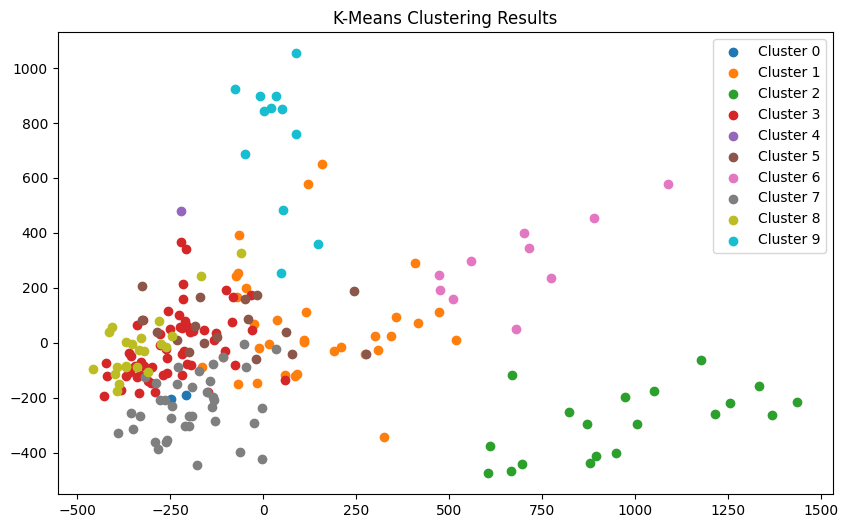

In [404]:
kmeans, clusters = run_k_means(image_features, num_clusters=10, log=False)
run_PCA_plot_2d(image_features, clusters, title="K-Means")

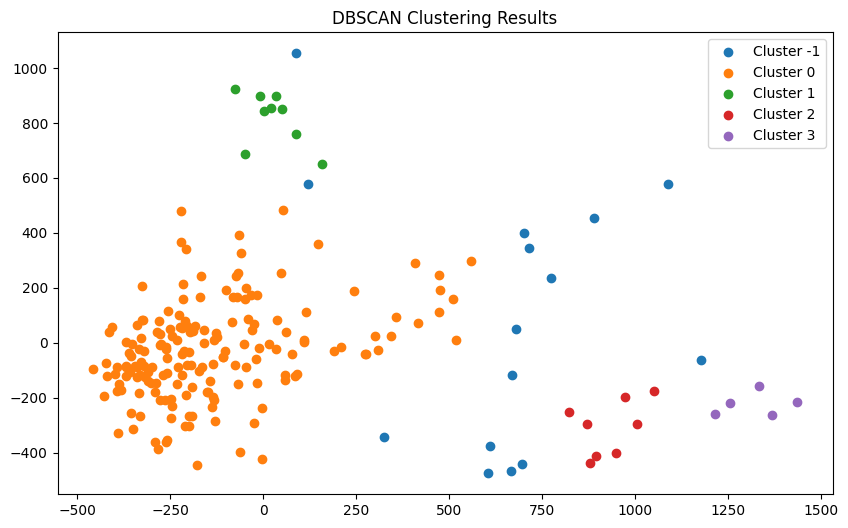

In [405]:
clusters = run_dbscan(image_features_pca, eps=160, min_samples=5, log=False)
run_PCA_plot_2d(image_features_pca, clusters, title="DBSCAN")

#### **Question 8.**

#### **Silhouette Score**

TThe Silhouette Score is a measure of how well each data point fits within its assigned cluster and how poorly it fits into other clusters. A higher Silhouette Score indicates that the data points are well-clustered, and the clusters are distinct and well-separated. This metric is a numerical measure that falls within the range of -1 to 1.


$$\text{{silhouette_score}} = \frac{{b - a}}{{\max(a, b)}}$$

steps:
1. The intra-cluster distance ($a$) is calculated. This is the average distance between a sample and all other samples within the `same` cluster.
2. Then the inter-cluster distance ($b$) is calculated. This is the average distance between a sample and all samples in the `nearest neighboring` cluster.
3. The Silhouette Score for the sample is computed using the formula above.

We repeat these steps for all samples and the average Silhouette Score is the overall Silhouette Score for the clustering result.



##### **Homogeneity Score**
The Homogeneity Score is a measure of whether each cluster contains only members of a single class. A higher Homogeneity Score indicates that the clusters align well with the pre-existing classes or labels in the data.Specifically, it measures the degree to which each cluster predominantly consists of data points from a single class, providing insights into the cohesion of clusters with respect to class membership.


$$H = \frac{1}{N} \sum \left(\frac{{\max(\text{{class_count}})}}{{N_{\text{{cluster}}}}}\right)$$

- N: Total number of sample
- N_cluster: Number of samples in the cluster
- max{class_count}: count of the most frequent class label

steps:
1. Assigning Data Points to Clusters
2. Computing Entropy of Class Labels
3. Computing Conditional Entropy of Class Labels Given Clusters
4. Calculating Homogeneity Score


#### **Question 9.**

Done!

#### **Question 10.**

Improving models and their outputs can be achieved through various strategies. Here are some general approaches:

1. **Collecting More Data**: More data can lead to better model performance as it allows the model to learn more patterns and reduce overfitting.

2. **Data Preprocessing**: Better preprocessing and feature scaling like saturation and brightness can improve model performance.

3. **Feature Engineering**: Models can struggle with high-dimensional data due to the curse of dimensionality. We can use dimensionality reduction techniques like PCA. DBSCAN uses distances, so if features are on different scales, it can lead to poor clustering results. We can solve it by normalizing or standardizing the features.

4. **Optimization Algorithms**: We can use optimization algorithms to improve the parameters of DBSCAN. For example, an efficient DBSCAN optimized by arithmetic optimization algorithm (OBLAOA-DBSCAN) can provide highly accurate clusters more efficiently.

5. **K-DBSCAN**: K-DBSCAN is an improved DBSCAN algorithm for big data. It applies an initial grouping to the data through the K-means++ algorithm, then employs DBSCAN to perform clustering in each group separately. This reduces the computational burden of DBSCAN execution and increases the clustering execution speed significantly.